## Homework 4

(In the following set $\alpha = 0.05$, $M=500$)

1. Comparing Bootstrap and Permutation Testing
    * Generate two arrays of 50 (each) random samples from a normal distribution, each with mean $\mu_1=\mu_2=50$, but with different stdevs: $\sigma_1 = 1, \sigma_2 = 4$.
    * Based on those two samples, test the Null Hypothesis $H_0: \mu_1=\mu_2$, $H_A: \mu_1 \neq \mu_2$ in two ways: (i) Bootstrap and (ii) Permutation.
    * Repeat the previous two steps (in a loop) $500$ times and save the test decisions in an array. 
    * Compute the type-I error rates for the two test procedures. Discuss your findings.
2. Random Walks
    * Adjust the code from the lesson such that you are simulating a **biased** random walk that imitates Web clicks: With probability $p=0.1$ you take a positive step $x=1$ (yes click), and with $p=0.9$ you stay where you are $x=0$ (no click). "Launch" $1000$ walkers for $400$ time steps each.
    * Write a function that (for each walker) tests the Null Hypothesis $H_0: p \leq 0.05$, $H_A: p > 0.05$ by applying this rule
    $$t = \frac{\sqrt{n} \cdot (\hat{p}- 0.05)}{\sqrt{0.05 \cdot 0.95}} > z_{1- \alpha} $$ where $\hat{p} = \sum x/n$ is the observed proportion of "ones" up to time step $n$.
    * Compute the type-II error rates for time steps $50$, $100$ and $400$.
    * Wouldn't it be nice to deploy an "early stopping" rule ? Try out the following strategy: stop the test **at any time** if your test statistic exceeds the threshold $z_{1- \alpha}$!
        * Compute your type-I error at the end of the $400$ time steps and compare to the one you set ($\alpha$).




In [1]:
%run ../Lessons/ourFunctions.py

## Comparing Bootstrap and Permutation Testing

In [26]:
def Bootstrap2Normals(mu1=0,mu2=0,s1=1,s2=4,n=50,M=500,alpha=0.05):
    x1= stats.norm.rvs(mu1,s1,n)
    x2= stats.norm.rvs(mu2,s2,n)
    
    meanNull = np.mean(np.concatenate([x1,x2]))
    empirical_diff_means = np.abs(np.mean(x1)-np.mean(x2))
    
    x1_shifted = x1 - np.mean(x1) + meanNull
    x2_shifted = x2 - np.mean(x2) + meanNull

    bs_replicates_1 = draw_bs_reps(x1_shifted, np.mean, M)
    bs_replicates_2 = draw_bs_reps(x2_shifted, np.mean, M)

    # Get replicates of difference of means: bs_replicates
    bs_replicates = bs_replicates_1 - bs_replicates_2
    
    pVal = np.mean( np.abs(bs_replicates) >= empirical_diff_means)
    
    return pVal < alpha


def Permutation2Normals(mu1=0,mu2=0,s1=1,s2=4,n=50,M=500,alpha=0.05):
    x1= stats.norm.rvs(mu1,s1,n)
    x2= stats.norm.rvs(mu2,s2,n)
    
    meanNull = np.mean(np.concatenate([x1,x2]))
    empirical_diff_means = np.abs(np.mean(x1)-np.mean(x2))

    # Get replicates of difference of means: bs_replicates
    perm_replicates = draw_perm_reps(x1, x2, diff_of_means, M)
    
    pVal = np.mean( np.abs(perm_replicates) >= empirical_diff_means)
    
    return pVal < alpha

In [12]:
mu1=0;mu2=0;s1=1;s2=4;n=50;M=1000;alpha=0.05
x1= stats.norm.rvs(mu1,s1,n)
x2= stats.norm.rvs(mu2,s2,n)
    
meanNull = np.mean(np.concatenate([x1,x2]))
meanNull
empirical_diff_means = np.abs(np.mean(x1)-np.mean(x2))
empirical_diff_means

0.45129236656489585

In [30]:
N = 500
TypeI = np.empty([N,2])
for i in range(N):
    TypeI[i,0] = Bootstrap2Normals()
    TypeI[i,1] = Permutation2Normals()

In [31]:
np.mean(TypeI,0)

array([0.048, 0.068])

In [34]:
TypeI_df = pd.DataFrame(TypeI)
TypeI_df.to_hdf("Type1.h5", key='df', mode='w')

----------------------------------------------------
## Random Walks

In [61]:
def BiasedWalk(p0=0.1, nwalks = 5000, nsteps = 400): 
    draws = np.random.uniform(0, 1, size=(nwalks, nsteps)) # 0 or 1
    steps = np.where(draws > p0, 0, 1)
    walks = steps.cumsum(1)
    return walks

nwalks = 5000
walks = BiasedWalk()
walks.shape[0]

5000

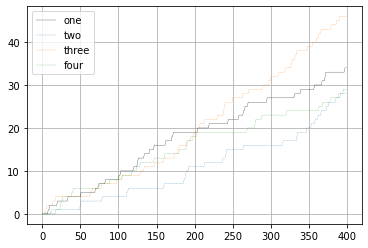

In [38]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(walks[1,:], 'k', label='one', linewidth=0.25)
ax.plot(walks[2,:], label='two', linestyle ='--', linewidth=0.25)
ax.plot(walks[3,:],  label='three', linestyle ='--', linewidth=0.25)
ax.plot(walks[4,:],  label='four', linestyle ='--', linewidth=0.25)
ax.grid()
#a very useless legend just because we can
ax.legend(loc='best')

In [55]:
def TypeIIranWalk(walks, p0=0.05, timestep=50, alpha = 0.05):
    nwalks = walks.shape[0]
    TypeII = np.empty(nwalks)
    zCrit = stats.norm.ppf(1-alpha) # = 1.65
    for i in range(nwalks):
        pHat = walks[i,timestep-1]/timestep
        t = np.sqrt(timestep)*(pHat-p0)/np.sqrt(p0*(1-p0))
        TypeII[i] = (t <= zCrit ) #no reject
    #at this poinnt TypeII is a vector of lenght 5000

    return np.mean(TypeII)

In [58]:
print(TypeIIranWalk(walks, timestep=50))
print(TypeIIranWalk(walks, timestep=100))
print(TypeIIranWalk(walks, timestep=400))

0.6168
0.3252
0.0144


In [81]:
def TypeIranWalk_sequential(walks, p0=0.05, alpha = 0.05):
    nwalks = walks.shape[0]
    nsteps = walks.shape[1]
    steps = (np.arange(nsteps)+1)
    
    TypeI = np.empty(nwalks)
    zCrit = stats.norm.ppf(1-alpha)
    
    for i in range(nwalks):
        pHat = walks[i,:]/steps
        t = np.sqrt(steps)*(pHat-p0)/np.sqrt(p0*(1-p0))
        TypeI[i] = np.any((t > zCrit )) # reject
    return np.mean(TypeI)

In [83]:
walks0 = BiasedWalk(p0=0.05)
TypeIranWalk_sequential(walks0)

0.4148

In [72]:
#debugging:
i=1;p0=0.05
nwalks = walks.shape[0]
nsteps = walks.shape[1]
steps = (np.arange(nsteps)+1)
zCrit = stats.norm.ppf(1-alpha)
pHat = walks[i,:]/steps
t = np.sqrt(steps)*(pHat-p0)/np.sqrt(p0*(1-p0))

In [80]:
np.any((t > 2 ))

True

In [75]:
zCrit

1.6448536269514722